# 模型

\begin{align}
h_\theta(x^{(i)}) &= \theta_0 + \theta_1x_1+ \theta_2 x_2 +\theta_n x_n\\
&=(x^{(i)})^T \theta
\end{align}

# 学习策略

最小化训练样本的真实值与预测值的误差

目标函数：
$$J(\theta)=\frac {1}{2m} \sum_{i=1}^{m} {(h_\theta(x^{(i)})-y^{(i)})^2}$$

其中，`m`为训练样本数量

**[基于极大似然估计的推导](https://millearninggroup.github.io/Stanford-CS229-CN/translation/cs229-notes1-cn/)**

# 学习算法

## 正规方程

$$\theta= (X^TX )^{-1}X^T\overset{\rightarrow} y$$

## 梯度下降

代价函数偏导数的推导：

假设只有一个样本(x,y)

![](https://millearninggroup.github.io/Stanford-CS229-CN/assets/image/notes1-LMS-1.jpg)

推广到 `m` 个样本的偏导数：
$$\frac{\partial}{\partial \theta_j}J(\theta)= \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$$

# Python实现

In [1]:
from __future__ import print_function, division
import numpy as np
import math
from sklearn.metrics import mean_squared_error

## 回归基类

In [2]:
class Regression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
    variables X. 
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_iterations, learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate

    def initialize_weights(self, n_features):
        """ Initialize weights randomly [-1/N, 1/N] """
        limit = 1 / math.sqrt(n_features)
        self.w = np.random.uniform(-limit, limit, (n_features, ))

    def fit(self, X, y):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            # Calculate l2 loss
            mse = np.mean(0.5 * (y - y_pred)**2 + self.regularization(self.w))
            self.training_errors.append(mse)
            # Gradient of l2 loss w.r.t w
            grad_w = -(y - y_pred).dot(X) + self.regularization.grad(self.w)
            # Update the weights
            self.w -= self.learning_rate * grad_w

    def predict(self, X):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

## 正则化

In [23]:
np.linalg.norm(np.array([-1,-2]))

2.2360679774997898

In [3]:
class l1_regularization():
    """ Regularization for Lasso Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * np.linalg.norm(w)

    def grad(self, w):
        return self.alpha * np.sign(w)

class l2_regularization():
    """ Regularization for Ridge Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * 0.5 *  w.T.dot(w)

    def grad(self, w):
        return self.alpha * w

class l1_l2_regularization():
    """ Regularization for Elastic Net Regression """
    def __init__(self, alpha, l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def __call__(self, w):
        l1_contr = self.l1_ratio * np.linalg.norm(w)
        l2_contr = (1 - self.l1_ratio) * 0.5 * w.T.dot(w) 
        return self.alpha * (l1_contr + l2_contr)

    def grad(self, w):
        l1_contr = self.l1_ratio * np.sign(w)
        l2_contr = (1 - self.l1_ratio) * w
        return self.alpha * (l1_contr + l2_contr) 

## 线性回归

In [4]:
class LinearRegression(Regression):
    """.
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If 
        false then we use batch optimization by least squares.
    """
    def __init__(self, n_iterations=100, learning_rate=0.001, gradient_descent=True):
        self.gradient_descent = gradient_descent
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(LinearRegression, self).__init__(n_iterations=n_iterations,
                                            learning_rate=learning_rate)
    def fit(self, X, y):
        # If not gradient descent => Least squares approximation of w
        if not self.gradient_descent:
            # Insert constant ones for bias weights
            X = np.insert(X, 0, 1, axis=1)
            # Calculate weights by least squares (using Moore-Penrose pseudoinverse)
            U, S, V = np.linalg.svd(X.T.dot(X))
            S = np.diag(S)
            X_sq_reg_inv = V.dot(np.linalg.pinv(S)).dot(U.T)
            self.w = X_sq_reg_inv.dot(X.T).dot(y)
        else:
            super(LinearRegression, self).fit(X, y)

## Lasso回归

In [5]:
class LassoRegression(Regression):
    """Linear regression model with a regularization factor which does both variable selection 
    and regularization. Model that tries to balance the fit of the model with respect to the training 
    data and the complexity of the model. A large regularization factor with decreases the variance of 
    the model and do para.
    Parameters:
    -----------
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01):
        self.degree = degree
        self.regularization = l1_regularization(alpha=reg_factor)
        super(LassoRegression, self).__init__(n_iterations, 
                                            learning_rate)

## 岭回归

In [6]:
class RidgeRegression(Regression):
    """Also referred to as Tikhonov regularization. Linear regression model with a regularization factor.
    Model that tries to balance the fit of the model with respect to the training data and the complexity
    of the model. A large regularization factor with decreases the variance of the model.
    Parameters:
    -----------
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, reg_factor, n_iterations=1000, learning_rate=0.001):
        self.regularization = l2_regularization(alpha=reg_factor)
        super(RidgeRegression, self).__init__(n_iterations, 
                                            learning_rate)

## ElasticNet回归

In [7]:
class ElasticNet(Regression):
    """ Regression where a combination of l1 and l2 regularization are used. The
    ratio of their contributions are set with the 'l1_ratio' parameter.
    Parameters:
    -----------
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    l1_ration: float
        Weighs the contribution of l1 and l2 regularization.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, reg_factor=0.05, l1_ratio=0.5, n_iterations=3000, 
                learning_rate=0.01):
        self.regularization = l1_l2_regularization(alpha=reg_factor, l1_ratio=l1_ratio)
        super(ElasticNet, self).__init__(n_iterations, 
                                        learning_rate)

## 多项式回归

In [8]:
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegression(Regression):
    """Performs a non-linear transformation of the data before fitting the model
    and doing predictions which allows for doing non-linear regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, n_iterations=3000, learning_rate=0.001):
        self.degree = degree
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(PolynomialRegression, self).__init__(n_iterations=n_iterations,
                                                learning_rate=learning_rate)

    def fit(self, X, y):
        self.poly = PolynomialFeatures(self.degree)
        X = self.poly.fit_transform(X)
        super(PolynomialRegression, self).fit(X, y)

    def predict(self, X):
        X = self.poly.transform(X)
        return super(PolynomialRegression, self).predict(X)

## 多项式岭回归

In [9]:
class PolynomialRidgeRegression(Regression):
    """Similar to regular ridge regression except that the data is transformed to allow
    for polynomial regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=100, learning_rate=0.001, gradient_descent=True):
        self.degree = degree
        self.regularization = l2_regularization(alpha=reg_factor)
        super(PolynomialRidgeRegression, self).__init__(n_iterations, 
                                                        learning_rate)

    def fit(self, X, y):
        self.poly = PolynomialFeatures(self.degree)
        X = self.poly.fit_transform(X)
        super(PolynomialRidgeRegression, self).fit(X, y)

    def predict(self, X):
        X = self.poly.transform(X)
        return super(PolynomialRidgeRegression, self).predict(X)

## 测试用例

### 模型训练

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


X, y = make_regression(n_samples=100, n_features=1, noise=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

n_samples, n_features = np.shape(X)

model = PolynomialRidgeRegression(degree=2,reg_factor=0.1)

model.fit(X_train, y_train)

### 学习曲线

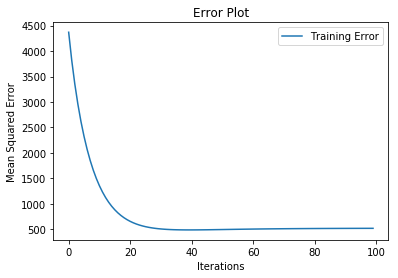

In [11]:
# Training error plot
n = len(model.training_errors)
training, = plt.plot(range(n), model.training_errors, label="Training Error")
plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('Mean Squared Error')
plt.xlabel('Iterations')
plt.show()

### 模型预测

In [12]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print ("Mean squared error: %s" % (mse))

Mean squared error: 589.05823077


### 模型拟合情况

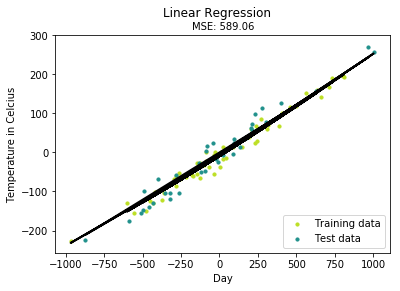

In [13]:
y_pred_line = model.predict(X)

# Color map
cmap = plt.get_cmap('viridis')

# Plot the results
m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
plt.plot(366 * X, y_pred_line, color='black', linewidth=2, label="Prediction")
plt.suptitle("Linear Regression")
plt.title("MSE: %.2f" % mse, fontsize=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()

# sklearn实现

In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Reference:
- [cs229 Note1](https://millearninggroup.github.io/Stanford-CS229-CN/translation/cs229-notes1-cn/)
- [线性回归原理小结](http://www.cnblogs.com/pinard/p/6004041.html)
- [scikit-learn 线性回归算法库小结](http://www.cnblogs.com/pinard/p/6026343.html)